# Spatial Transcriptomics Clustering Analysis with Scanpy

This notebook demonstrates a comprehensive single-cell spatial transcriptomics analysis workflow using scanpy and standard Python libraries.

**Author:** Generated for ST Course  
**Date:** 2026-02-01  
**Input Data:** SS200000141TL_B5_raw.h5ad

## Workflow Overview:
1. Data Loading & Inspection
2. Quality Control (QC)
3. Filtering
4. Normalization
5. Feature Selection (Highly Variable Genes)
6. Dimensionality Reduction (PCA, UMAP)
7. Clustering (Leiden, Louvain)
8. Marker Gene Identification
9. Visualization

## 1. Import Libraries

In [1]:
pip install leidenalg

In [2]:
pip install scanpy

In [3]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Single-cell analysis
import scanpy as sc
import anndata as ad

# Configure plotting
warnings.filterwarnings('ignore')
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)
sc.logging.print_header()

# Set random seed for reproducibility
np.random.seed(42)

print(f"Scanpy version: {sc.__version__}")
print(f"AnnData version: {ad.__version__}")

Scanpy version: 1.12
AnnData version: 0.12.10


## 2. Data Loading & Initial Inspection

We load the spatial transcriptomics data stored in h5ad format. This format stores:
- Expression matrix (cells × genes)
- Cell metadata (observations)
- Gene metadata (variables)
- Spatial coordinates (if available)

In [4]:
!pip install gdown
import gdown

url = "https://drive.google.com/uc?id=1lRM-tR1MMbtgyKXLqRzV2YxokweiNUMz"
data_path = "adult_mouse_brain_ST4k.h5ad"
gdown.download(url, data_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1lRM-tR1MMbtgyKXLqRzV2YxokweiNUMz
To: /content/adult_mouse_brain_ST4k.h5ad
100%|██████████| 5.71M/5.71M [00:00<00:00, 39.6MB/s]


'adult_mouse_brain_ST4k.h5ad'

In [5]:
# Load the h5ad file
adata = sc.read_h5ad(data_path)

print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)
print(f"Number of cells: {adata.n_obs:,}")
print(f"Number of genes: {adata.n_vars:,}")
print(f"Total counts: {adata.X.sum():,.0f}")
print("\nAnnData object structure:")
print(adata)


DATA SUMMARY
Number of cells: 4,000
Number of genes: 20,062
Total counts: 2,972,340

AnnData object structure:
AnnData object with n_obs × n_vars = 4000 × 20062
    obs: 'n_genes_by_counts'
    var: 'Symbol'
    obsm: 'spatial'


In [6]:
# Inspect available metadata
print("\nCell metadata (obs) columns:")
print(adata.obs.columns.tolist())

print("\nGene metadata (var) columns:")
print(adata.var.columns.tolist())

# Check if spatial coordinates are available
if 'spatial' in adata.obsm.keys():
    print("\n✓ Spatial coordinates found in adata.obsm['spatial']")
    print(f"  Coordinate dimensions: {adata.obsm['spatial'].shape}")
else:
    print("\n⚠ No spatial coordinates found")

# Display first few rows of cell metadata
print("\nFirst 5 cells (observations):")
display(adata.obs.head())

print("\nFirst 5 genes (variables):")
display(adata.var.head())


Cell metadata (obs) columns:
['n_genes_by_counts']

Gene metadata (var) columns:
['Symbol']

✓ Spatial coordinates found in adata.obsm['spatial']
  Coordinate dimensions: (4000, 3)

First 5 cells (observations):


n_genes_by_counts
SS200000141TL_B5-41021.0-0               3178
SS200000141TL_B5-45714.0-0               2564
SS200000141TL_B5-9573.0-0                3139
SS200000141TL_B5-12807.0-0               2433
SS200000141TL_B5-20601.0-0               3371


First 5 genes (variables):


Symbol
Symbol                      
0610009B22Rik  0610009B22Rik
0610010K14Rik  0610010K14Rik
0610012G03Rik  0610012G03Rik
0610030E20Rik  0610030E20Rik
0610040B10Rik  0610040B10Rik

## 3. Quality Control (QC)

We calculate QC metrics to assess data quality:
- **n_genes_by_counts**: Number of genes expressed per cell
- **total_counts**: Total UMI counts per cell
- **pct_counts_mt**: Percentage of mitochondrial gene expression (indicator of cell stress/death)

High mitochondrial content typically indicates poor quality or dying cells.

In [7]:
# Identify mitochondrial genes
# Common prefixes: 'mt-' (mouse), 'MT-' (human), or genes starting with 'Mt'
adata.var['mt'] = adata.var_names.str.lower().str.startswith('mt-') | \
                  adata.var_names.str.startswith('MT-') | \
                  adata.var_names.str.lower().str.startswith('mt')

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],  # Calculate percentage of mitochondrial genes
    percent_top=None,  # Don't calculate percentage of top genes
    log1p=False,  # Don't log-transform
    inplace=True
)

print("\n" + "="*80)
print("QC METRICS SUMMARY")
print("="*80)
print(f"Number of mitochondrial genes detected: {adata.var['mt'].sum()}")
print(f"\nQC metrics added to adata.obs:")
print([col for col in adata.obs.columns if col.startswith(('total_counts', 'n_genes', 'pct_counts'))])

# Display summary statistics
print("\nQC Statistics:")
qc_stats = adata.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']].describe()
display(qc_stats)


QC METRICS SUMMARY
Number of mitochondrial genes detected: 69

QC metrics added to adata.obs:
['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']

QC Statistics:


total_counts  n_genes_by_counts  pct_counts_mt
count   4000.000000        4000.000000    4000.000000
mean     743.085022         450.725000       0.816695
std      303.536621         165.332686       0.584300
min      239.000000         140.000000       0.000000
25%      508.000000         324.000000       0.421941
50%      701.000000         433.500000       0.713140
75%      932.000000         562.250000       1.084501
max     1874.000000         991.000000       5.084745

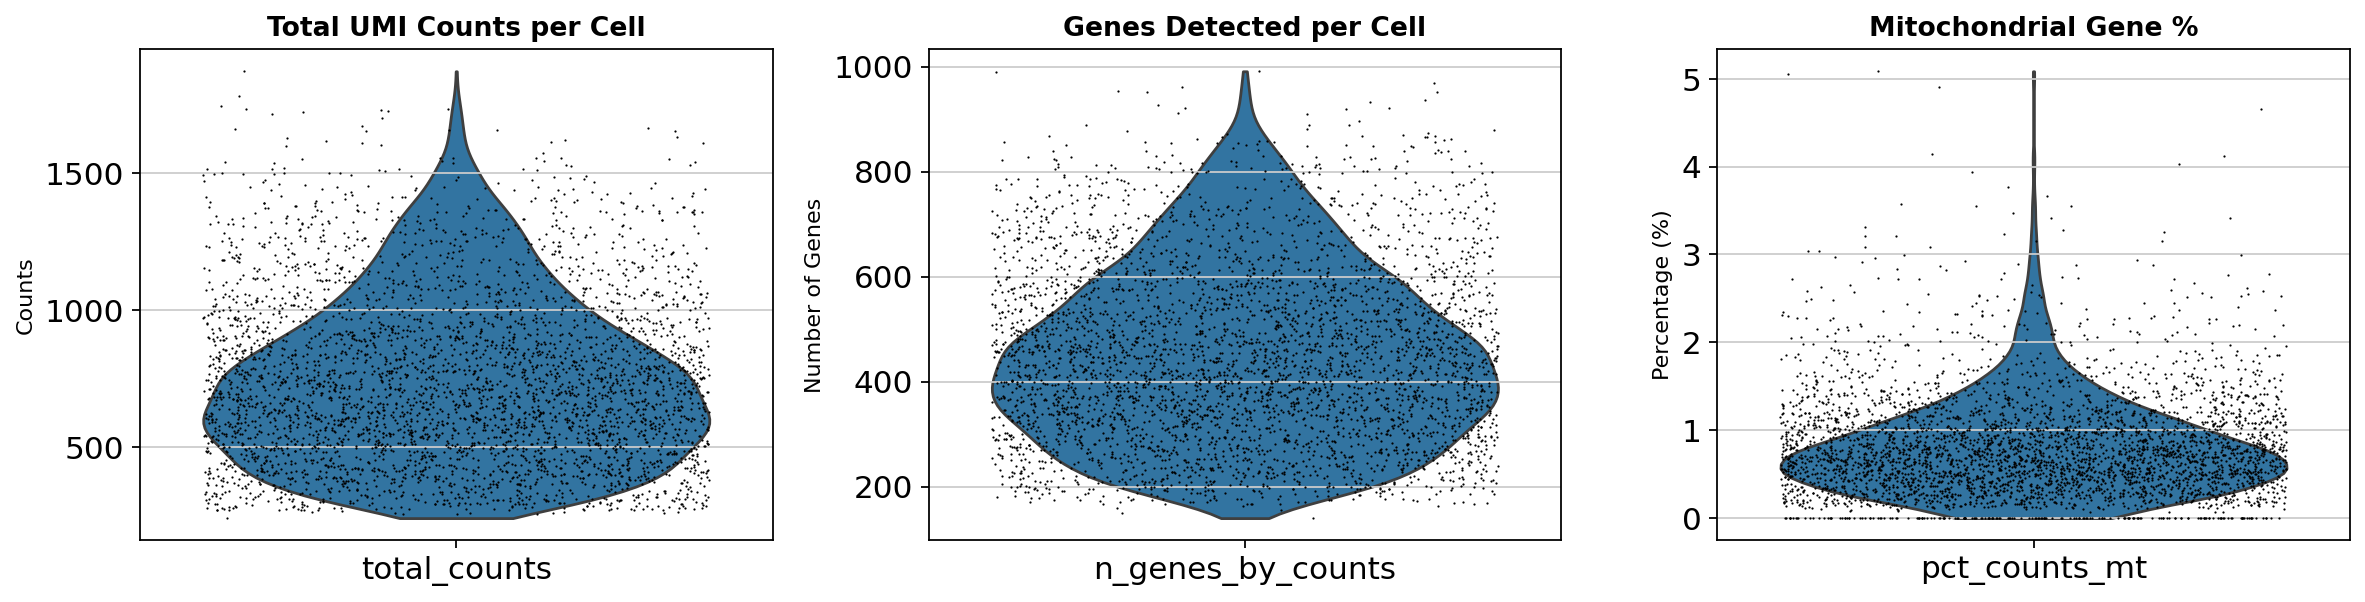


✓ QC violin plots generated


In [8]:
# Visualize QC metrics with violin plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total counts per cell
sc.pl.violin(
    adata,
    ['total_counts'],
    jitter=0.4,
    ax=axes[0],
    show=False
)
axes[0].set_title('Total UMI Counts per Cell', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Counts', fontsize=10)

# Number of genes per cell
sc.pl.violin(
    adata,
    ['n_genes_by_counts'],
    jitter=0.4,
    ax=axes[1],
    show=False
)
axes[1].set_title('Genes Detected per Cell', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Genes', fontsize=10)

# Mitochondrial percentage
sc.pl.violin(
    adata,
    ['pct_counts_mt'],
    jitter=0.4,
    ax=axes[2],
    show=False
)
axes[2].set_title('Mitochondrial Gene %', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Percentage (%)', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ QC violin plots generated")

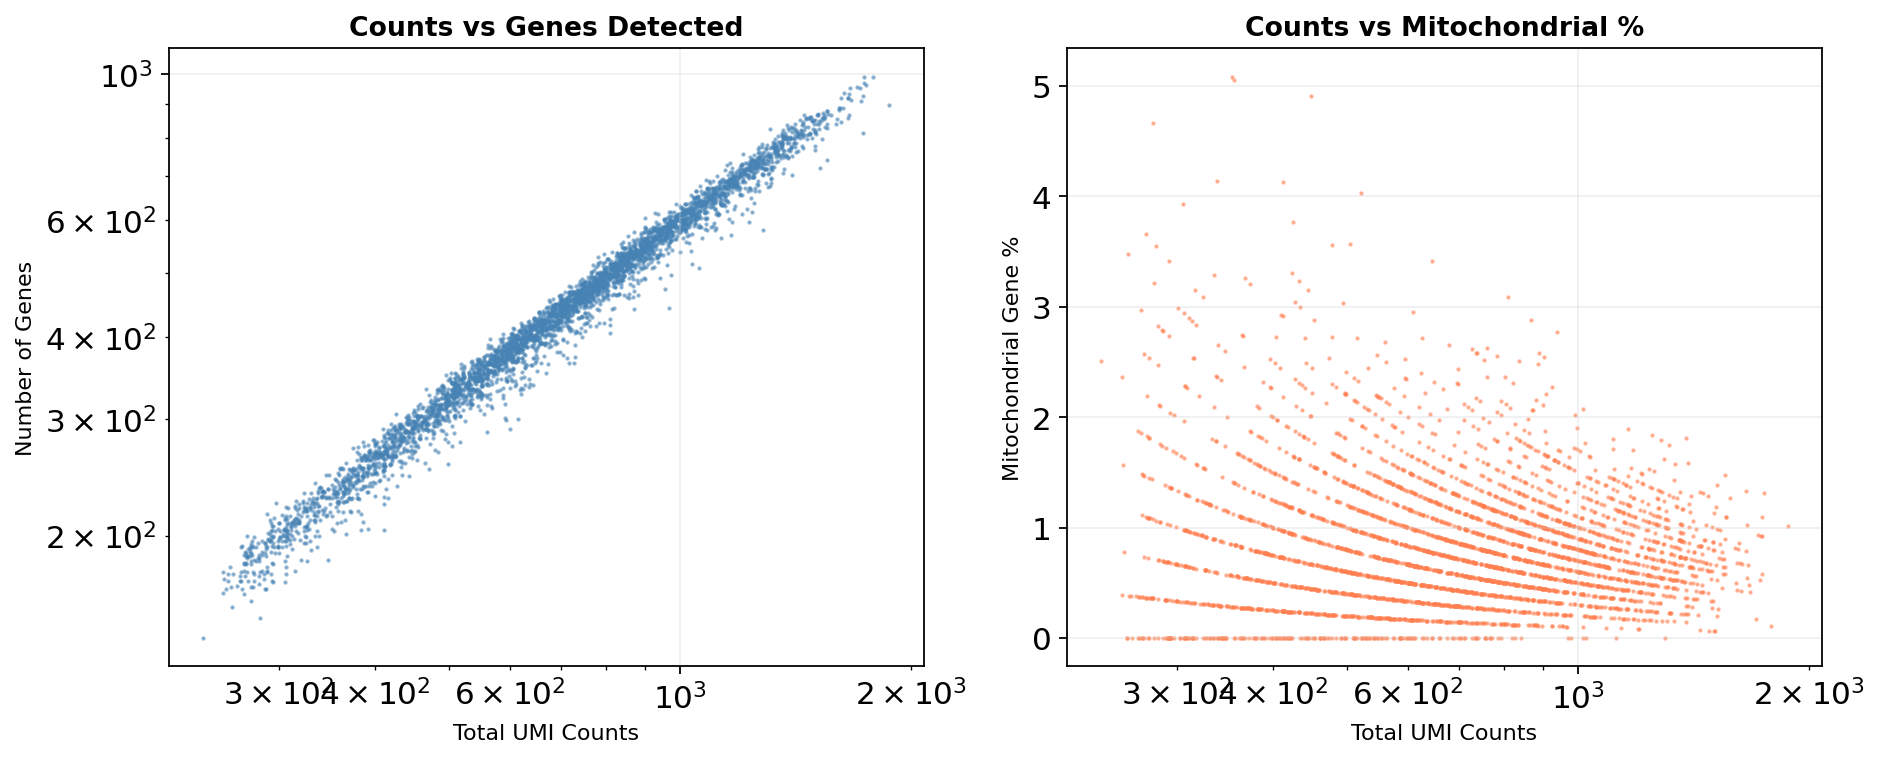


✓ QC scatter plots generated


In [9]:
# Scatter plots to identify outliers and correlations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Total counts vs genes detected
axes[0].scatter(
    adata.obs['total_counts'],
    adata.obs['n_genes_by_counts'],
    alpha=0.5,
    s=1,
    c='steelblue'
)
axes[0].set_xlabel('Total UMI Counts', fontsize=10)
axes[0].set_ylabel('Number of Genes', fontsize=10)
axes[0].set_title('Counts vs Genes Detected', fontsize=12, fontweight='bold')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Total counts vs mitochondrial percentage
axes[1].scatter(
    adata.obs['total_counts'],
    adata.obs['pct_counts_mt'],
    alpha=0.5,
    s=1,
    c='coral'
)
axes[1].set_xlabel('Total UMI Counts', fontsize=10)
axes[1].set_ylabel('Mitochondrial Gene %', fontsize=10)
axes[1].set_title('Counts vs Mitochondrial %', fontsize=12, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ QC scatter plots generated")

## 4. Filtering

We filter cells and genes based on QC metrics to remove low-quality data:

**Cell filtering criteria:**
- Minimum counts: 200 (cells with very low UMI counts)
- Minimum genes: 3 (cells expressing too few genes)
- Maximum genes: 2500 (potential doublets)
- Maximum mitochondrial %: 5% (dying/stressed cells)

**Gene filtering:**
- Minimum cells: 3 (genes expressed in very few cells)

In [10]:
print("\n" + "="*80)
print("FILTERING")
print("="*80)
print(f"Cells before filtering: {adata.n_obs:,}")
print(f"Genes before filtering: {adata.n_vars:,}")

# Define filtering thresholds
min_counts = 200
min_genes = 3
max_genes = 2500
max_pct_mt = 5.0

print(f"\nFiltering criteria:")
print(f"  - min_counts: {min_counts}")
print(f"  - min_genes: {min_genes}")
print(f"  - max_genes: {max_genes}")
print(f"  - max_pct_mt: {max_pct_mt}%")

# Filter cells based on QC metrics
sc.pp.filter_cells(adata, min_counts=min_counts)
sc.pp.filter_cells(adata, min_genes=min_genes)

# Remove cells with too many genes (potential doublets)
adata = adata[adata.obs['n_genes_by_counts'] < max_genes, :].copy()

# Remove cells with high mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < max_pct_mt, :].copy()

# Filter genes (keep genes expressed in at least 3 cells)
sc.pp.filter_genes(adata, min_cells=3)

print(f"\nCells after filtering: {adata.n_obs:,}")
print(f"Genes after filtering: {adata.n_vars:,}")
print(f"\nCells removed: {adata.n_obs - adata.n_obs:,}")
print(f"Genes removed: {adata.n_vars - adata.n_vars:,}")

# Store the raw data for later use (e.g., differential expression)
adata.layers["counts"] = adata.X.copy()
print("\n✓ Raw data checkpoint saved in adata.layers[counts]")


FILTERING
Cells before filtering: 4,000
Genes before filtering: 20,062

Filtering criteria:
  - min_counts: 200
  - min_genes: 3
  - max_genes: 2500
  - max_pct_mt: 5.0%
filtered out 5506 genes that are detected in less than 3 cells

Cells after filtering: 3,998
Genes after filtering: 14,556

Cells removed: 0
Genes removed: 0

✓ Raw data checkpoint saved in adata.layers[counts]


## 5. Normalization

Normalization removes technical variation and makes cells comparable:

1. **Total count normalization**: Scale each cell to have the same total counts (10,000 by default)
2. **Log transformation**: Apply log(x + 1) to stabilize variance and approximate normal distribution

This is equivalent to stereopy's `normalize_total()` + `log1p()`

In [11]:
import numpy as np
import scanpy as sc

print("\n" + "="*80)
print("NORMALIZATION")
print("="*80)

# ---------- Heuristic checks ----------
# Check if log1p was already applied
log1p_applied = (
    'log1p' in adata.uns or
    (adata.X.max() < 50 and np.any(adata.X < 0) is False)
)

# Check if total-count normalization was already applied
# (mean library size close to target_sum)
libsize = np.array(adata.X.sum(axis=1)).flatten()
mean_libsize = np.mean(libsize)
normalized = np.isclose(mean_libsize, 1e4, rtol=0.1)

print(f"Mean library size: {mean_libsize:.2f}")
print(f"Detected log1p: {log1p_applied}")
print(f"Detected total-count normalization: {normalized}")

# ---------- Apply steps conditionally ----------
if not normalized:
    sc.pp.normalize_total(adata, target_sum=1e4)
    print("✓ Total count normalization applied (target_sum=10,000)")
else:
    print("→ Skipping total count normalization (already normalized)")

if not log1p_applied:
    sc.pp.log1p(adata)
    print("✓ Log transformation applied [log(x + 1)]")
else:
    print("→ Skipping log1p (already log-transformed)")

print(f"\nFinal data shape: {adata.shape}")
print(f"Data type: {type(adata.X)}")
print(f"Data range: [{adata.X.min():.2f}, {adata.X.max():.2f}]")



NORMALIZATION
Mean library size: 742.13
Detected log1p: False
Detected total-count normalization: False
normalizing counts per cell
    finished (0:00:09)
✓ Total count normalization applied (target_sum=10,000)
✓ Log transformation applied [log(x + 1)]

Final data shape: (3998, 14556)
Data type: <class 'scipy.sparse._csr.csr_matrix'>
Data range: [0.00, 6.93]


## 6. Feature Selection: Highly Variable Genes (HVGs)

Not all genes are informative for cell type identification. We select highly variable genes that:
- Show significant variation across cells
- Capture biological variation rather than technical noise
- Reduce computational burden and noise in downstream analysis

We'll select the top 2,000 highly variable genes using the 'seurat' method.

In [12]:
print("\n" + "="*80)
print("HIGHLY VARIABLE GENES SELECTION")
print("="*80)

# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor='seurat',  # Use Seurat method (compatible with stereopy parameters)
)

print(f"Total genes: {adata.n_vars:,}")
print(f"Highly variable genes: {adata.var['highly_variable'].sum():,}")
print(f"Percentage: {100 * adata.var['highly_variable'].sum() / adata.n_vars:.2f}%")

# Display top highly variable genes
print("\nTop 10 most variable genes:")
top_hvgs = adata.var.sort_values('dispersions_norm', ascending=False).head(10)
display(top_hvgs[['highly_variable', 'means', 'dispersions', 'dispersions_norm']])


HIGHLY VARIABLE GENES SELECTION
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Total genes: 14,556
Highly variable genes: 2,000
Percentage: 13.74%

Top 10 most variable genes:


highly_variable     means  dispersions  dispersions_norm
Symbol                                                          
Cartpt             True  0.789927     4.528453          7.416334
Hba-a1             True  0.976522     4.639457          7.009076
Csmd1              True  1.111612     4.526912          6.382317
Ptprd              True  1.430266     4.743531          5.682499
Hbb-bs             True  1.857156     4.885263          5.442873
Trpm3              True  1.785028     4.859002          5.345987
Hba-a2             True  0.754807     4.135648          4.875776
Pcdh9              True  1.895956     4.100452          4.869122
Gpc5               True  1.887866     4.660932          4.615243
Trps1              True  0.963005     4.203746          4.582613

In [13]:
# Visualize highly variable genes
sc.pl.highly_variable_genes(adata, show=True)
print("\n✓ Highly variable genes plot generated")


✓ Highly variable genes plot generated


## Scaling (per gene)

In [14]:
# Scale for PCA and neighborhood graph construction
adata.layers["normlog"] = adata.X.copy() # Save normlog data
sc.pp.scale(adata) # Scaling is perform per gene - z-scores

## 7. Dimensionality Reduction: PCA

Principal Component Analysis (PCA) reduces the dimensionality of the data while preserving maximum variance:
- Transforms thousands of genes into a smaller set of principal components
- Each PC is a linear combination of genes
- First PCs capture the most biological variation

We compute 50 PCs and will use the top 30 for downstream analysis.

In [15]:
print("\n" + "="*80)
print("PCA COMPUTATION")
print("="*80)

# Compute PCA using highly variable genes
sc.tl.pca(
    adata,
    n_comps=50,  # Compute 50 principal components
    use_highly_variable=True,  # Use only highly variable genes
    svd_solver='arpack'  # Solver method (efficient for sparse data)
)

print(f"✓ PCA computed with {adata.obsm['X_pca'].shape[1]} components")
print(f"✓ Using {adata.var['highly_variable'].sum()} highly variable genes")

# Calculate variance explained by each PC
variance_ratio = adata.uns['pca']['variance_ratio']
print(f"\nVariance explained by first 10 PCs: {100 * variance_ratio[:10].sum():.2f}%")
print(f"Variance explained by first 30 PCs: {100 * variance_ratio[:30].sum():.2f}%")


PCA COMPUTATION
computing PCA
    with n_comps=50
    finished (0:00:10)
✓ PCA computed with 50 components
✓ Using 2000 highly variable genes

Variance explained by first 10 PCs: 2.60%
Variance explained by first 30 PCs: 5.66%


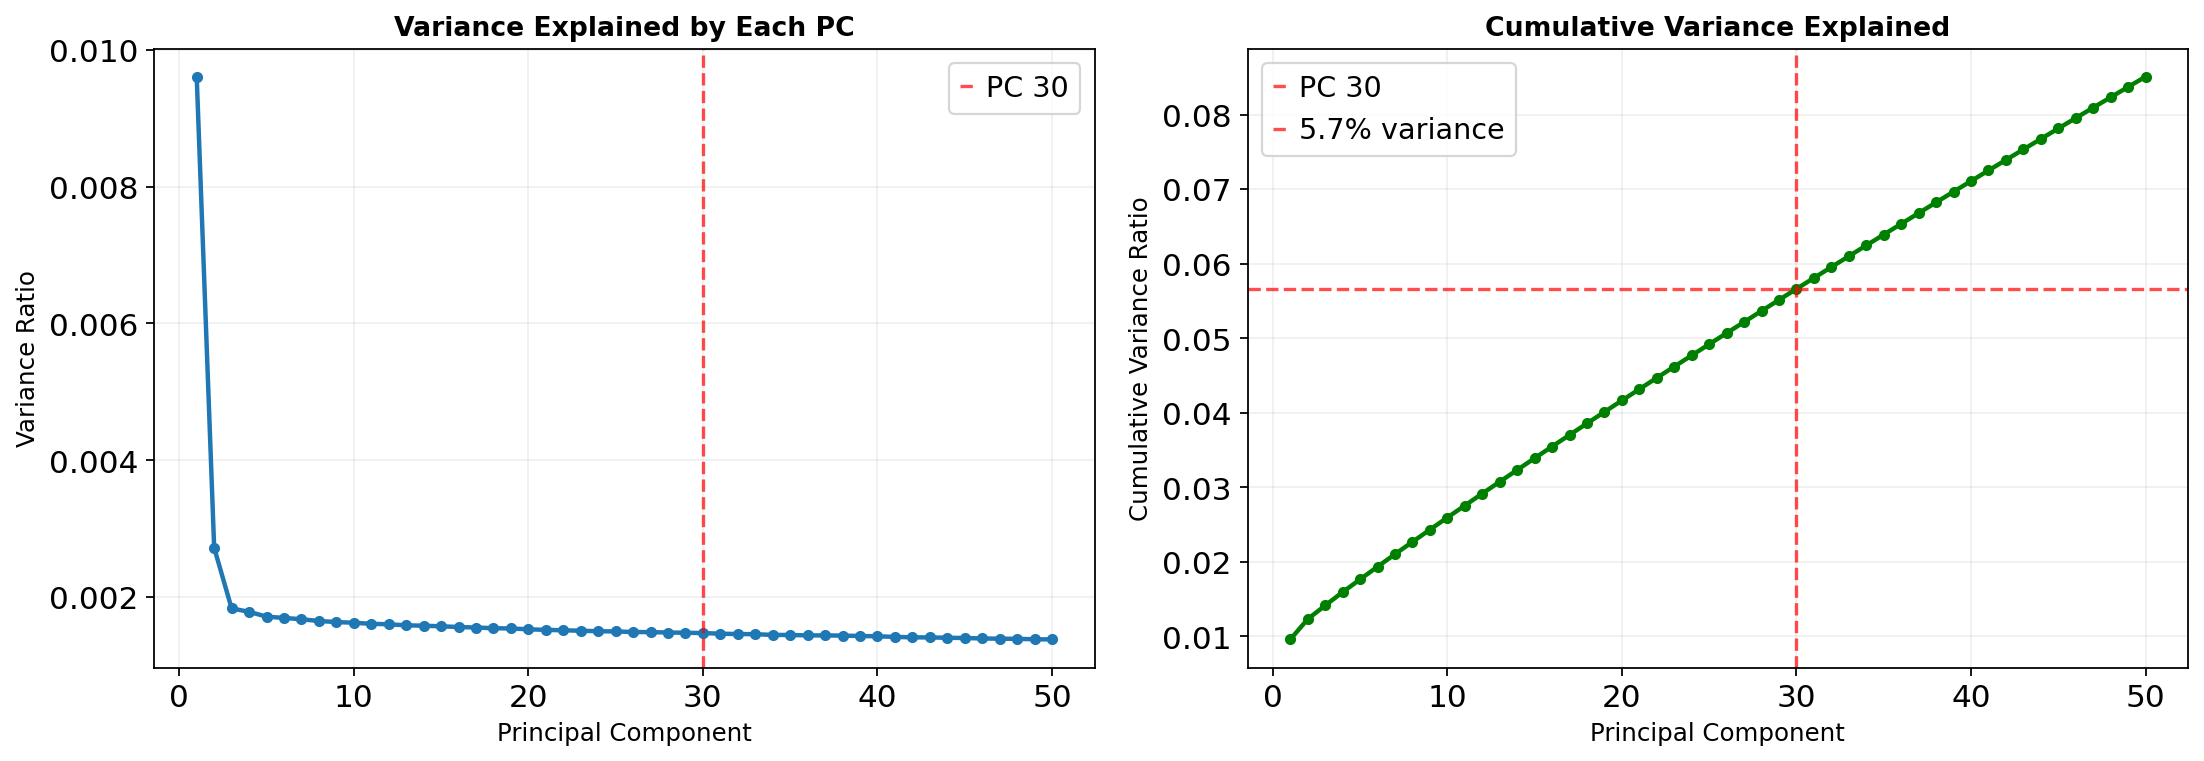


✓ Elbow plots generated - we'll use 30 PCs for downstream analysis


In [16]:
# Elbow plot to determine optimal number of PCs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Variance ratio plot
axes[0].plot(range(1, 51), adata.uns['pca']['variance_ratio'], 'o-', linewidth=2, markersize=4)
axes[0].axvline(x=30, color='red', linestyle='--', alpha=0.7, label='PC 30')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Variance Ratio', fontsize=11)
axes[0].set_title('Variance Explained by Each PC', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative variance plot
cumsum_var = np.cumsum(adata.uns['pca']['variance_ratio'])
axes[1].plot(range(1, 51), cumsum_var, 'o-', linewidth=2, markersize=4, color='green')
axes[1].axvline(x=30, color='red', linestyle='--', alpha=0.7, label='PC 30')
axes[1].axhline(y=cumsum_var[29], color='red', linestyle='--', alpha=0.7,
                label=f'{100*cumsum_var[29]:.1f}% variance')
axes[1].set_xlabel('Principal Component', fontsize=11)
axes[1].set_ylabel('Cumulative Variance Ratio', fontsize=11)
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Elbow plots generated - we'll use 30 PCs for downstream analysis")

## 8. Neighborhood Graph Construction

Build a k-nearest neighbors (kNN) graph in PCA space:
- Connects each cell to its k nearest neighbors
- Foundation for clustering and UMAP
- Uses the top 30 PCs

In [17]:
print("\n" + "="*80)
print("NEIGHBORHOOD GRAPH")
print("="*80)

# Compute neighborhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=15,  # Number of neighbors to consider
    n_pcs=30,  # Use top 30 principal components
    metric='euclidean'  # Distance metric
)

print("✓ Neighborhood graph computed")
print(f"  - Number of neighbors: 15")
print(f"  - PCs used: 30")
print(f"  - Metric: euclidean")
print(f"\nGraph stored in:")
print(f"  - adata.obsp['distances']: distance matrix")
print(f"  - adata.obsp['connectivities']: connectivity matrix")


NEIGHBORHOOD GRAPH
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
✓ Neighborhood graph computed
  - Number of neighbors: 15
  - PCs used: 30
  - Metric: euclidean

Graph stored in:
  - adata.obsp['distances']: distance matrix
  - adata.obsp['connectivities']: connectivity matrix


## 9. UMAP Embedding

Uniform Manifold Approximation and Projection (UMAP):
- Non-linear dimensionality reduction to 2D
- Preserves both local and global structure
- Better for visualization than PCA
- Clusters that are close in UMAP space are similar in high-dimensional space

In [18]:
print("\n" + "="*80)
print("UMAP EMBEDDING")
print("="*80)

# Compute UMAP embedding
sc.tl.umap(
    adata,
    min_dist=0.4, # Prevents over-fragmentation caused by dropout
    # min_dist=0.25 Emphasize discrete domains
    spread=1.0, # Keeps embedding readable without exaggeration
    n_components=2,
    random_state=0
)


print("✓ UMAP embedding computed")
print(f"  - Embedding dimensions: {adata.obsm['X_umap'].shape}")
print(f"  - min_dist: 0.5")
print(f"  - spread: 1.0")


UMAP EMBEDDING
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)
✓ UMAP embedding computed
  - Embedding dimensions: (3998, 2)
  - min_dist: 0.5
  - spread: 1.0


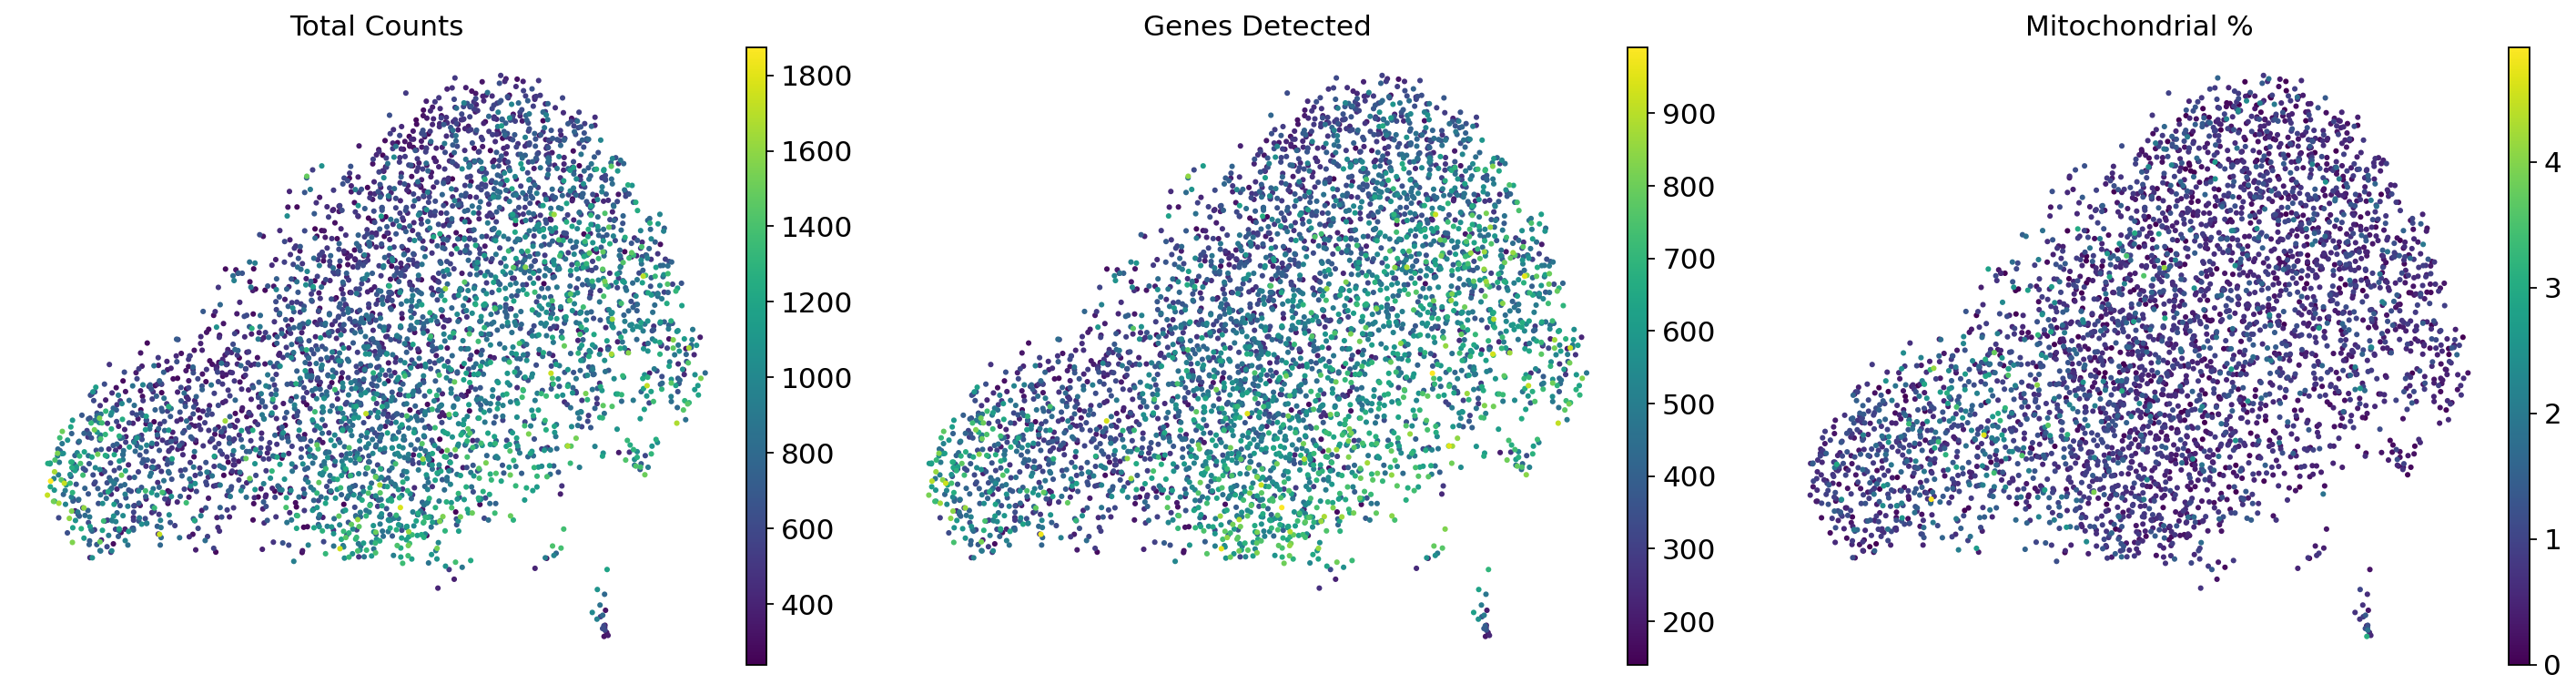


✓ UMAP plots with QC metrics generated


In [19]:
# Visualize UMAP colored by QC metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata, color='total_counts', ax=axes[0], show=False, title='Total Counts')
sc.pl.umap(adata, color='n_genes_by_counts', ax=axes[1], show=False, title='Genes Detected')
sc.pl.umap(adata, color='pct_counts_mt', ax=axes[2], show=False, title='Mitochondrial %')

plt.tight_layout()
plt.show()

print("\n✓ UMAP plots with QC metrics generated")

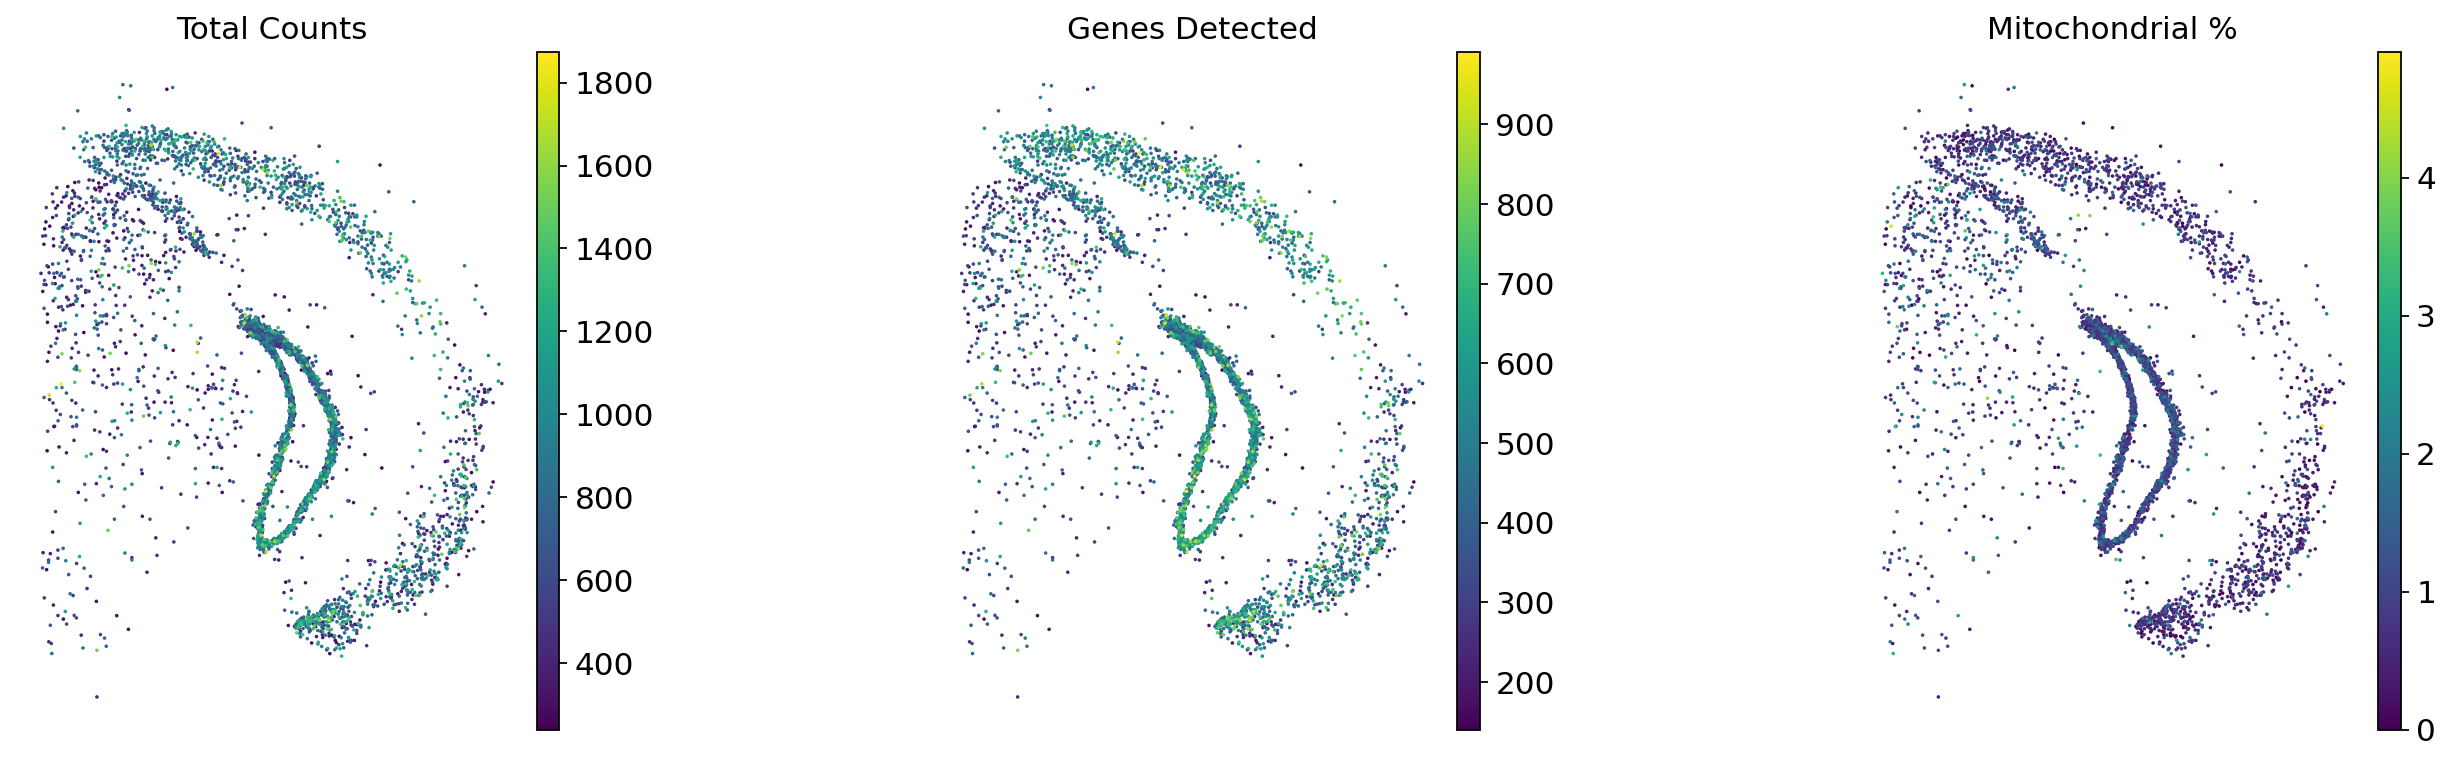

In [20]:
import matplotlib.pyplot as plt
import scanpy as sc

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Spatial plots for QC metrics
sc.pl.spatial(
    adata,
    color='total_counts',
    ax=axes[0],
    show=False,
    title='Total Counts',
    spot_size=60
)
sc.pl.spatial(
    adata,
    color='n_genes_by_counts',
    ax=axes[1],
    show=False,
    title='Genes Detected',
    spot_size=60
)
sc.pl.spatial(
    adata,
    color='pct_counts_mt',
    ax=axes[2],
    show=False,
    title='Mitochondrial %',
    spot_size=60
)

plt.tight_layout()
plt.show()


## 10. Clustering

We'll apply two community detection algorithms to identify cell clusters:

### 10.1 Leiden Clustering (Recommended)
- Optimization of the Louvain algorithm
- Guarantees well-connected communities
- More accurate and faster
- `resolution` parameter controls granularity (higher = more clusters)

In [21]:
print("\n" + "="*80)
print("LEIDEN CLUSTERING")
print("="*80)

# Leiden clustering
sc.tl.leiden(
    adata,
    resolution=0.4,  # Resolution parameter (higher = more clusters)
    random_state=42,  # For reproducibility
    key_added='leiden'  # Store results in adata.obs['leiden']
)

n_clusters = adata.obs['leiden'].nunique()
print(f"✓ Leiden clustering complete")
print(f"  - Resolution: 1.0")
print(f"  - Number of clusters: {n_clusters}")

# Display cluster sizes
cluster_sizes = adata.obs['leiden'].value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster, size in cluster_sizes.items():
    pct = 100 * size / adata.n_obs
    print(f"  Cluster {cluster}: {size:,} cells ({pct:.1f}%)")


LEIDEN CLUSTERING
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
✓ Leiden clustering complete
  - Resolution: 1.0
  - Number of clusters: 5

Cluster sizes:
  Cluster 0: 1,695 cells (42.4%)
  Cluster 1: 1,647 cells (41.2%)
  Cluster 2: 631 cells (15.8%)
  Cluster 3: 17 cells (0.4%)
  Cluster 4: 8 cells (0.2%)


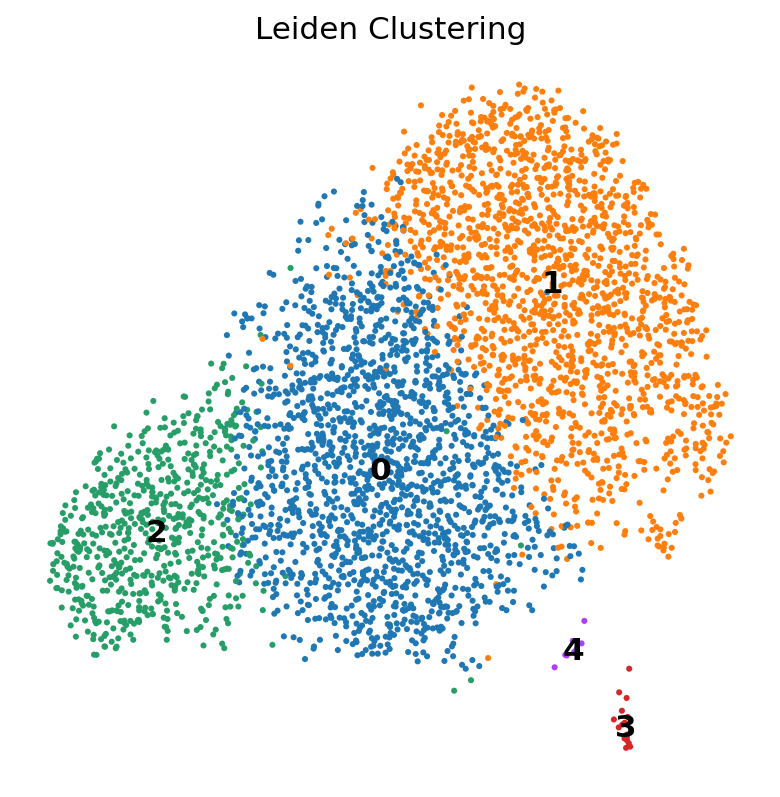


✓ Leiden UMAP plot generated


In [22]:
# Visualize Leiden clustering on UMAP
sc.settings.set_figure_params(figsize=(6, 6))
sc.pl.umap(
    adata,
    color='leiden',
    legend_loc='on data',
    title='Leiden Clustering',
    frameon=False,
    save=False
)

print("\n✓ Leiden UMAP plot generated")

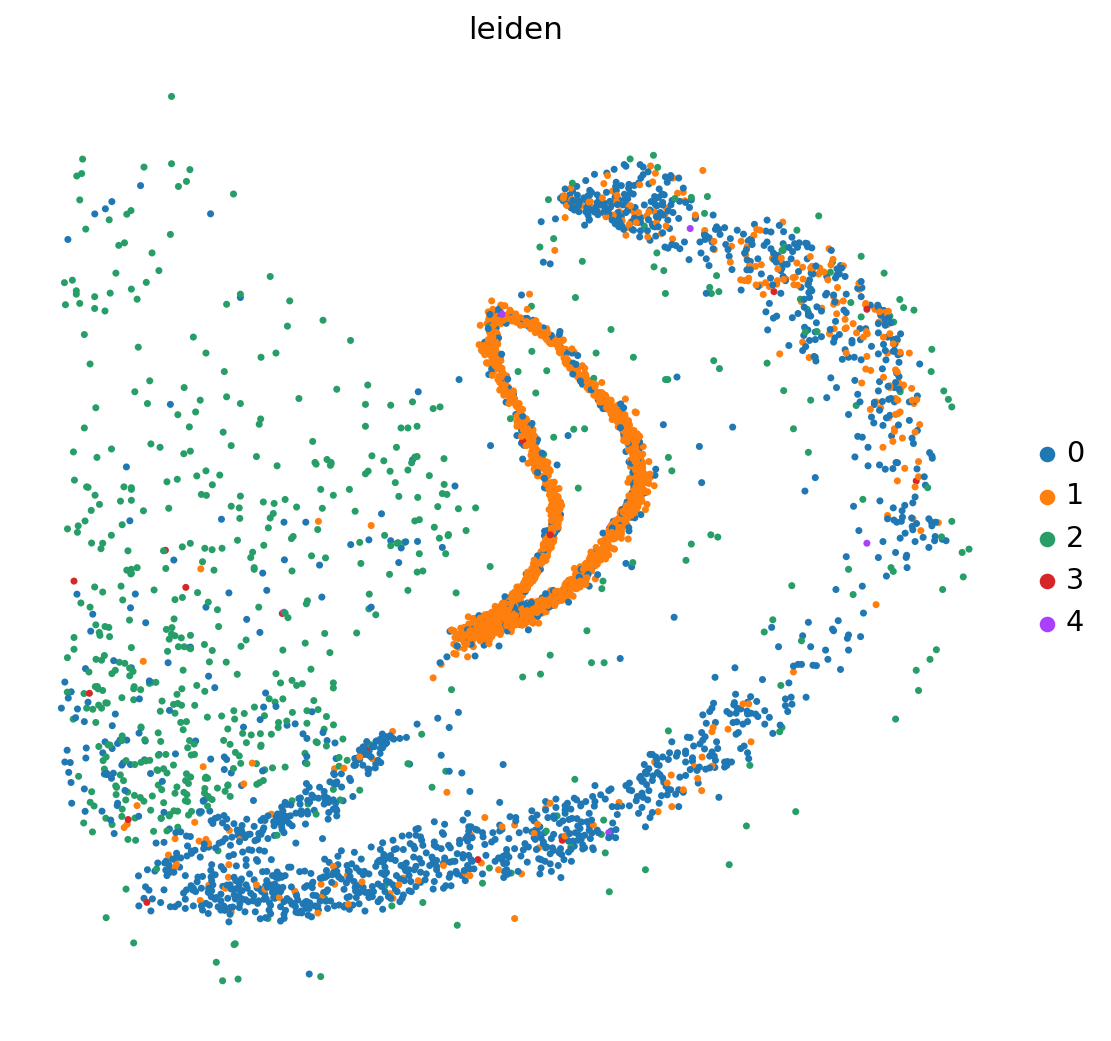

In [23]:
sc.settings.set_figure_params(figsize=(8, 8))
sc.pl.embedding(
    adata,
    basis='spatial',
    color='leiden',
    size=40,
    frameon=False,
    # legend_loc='on data'
)


## 11. Marker Gene Identification

Find genes that are differentially expressed in each cluster:
- Uses raw, unscaled data from `adata.layers["counts"]`
- Statistical test: t-test with overestimated variance
- Compares each cluster vs all other cells
- Helps identify cell types based on known markers

In [24]:
print("\n" + "="*80)
print("MARKER GENE IDENTIFICATION")
print("="*80)

# Find marker genes for Leiden clusters
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',  # Group by Leiden clusters
    method='wilcoxon',  # Statistical test method - does not assume normal distribution, compares medians rather than mean
    layer="normlog",  # Statistical tests should be performed on log1p data
    key_added='rank_genes_leiden'
)

print("✓ Marker genes computed for Leiden clusters")
print(f"  - Method: wilcoxon")
print(f"  - Using raw data: False")
print(f"  - Clusters analyzed: {n_clusters}")


MARKER GENE IDENTIFICATION
ranking genes
    finished: added to `.uns['rank_genes_leiden']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
✓ Marker genes computed for Leiden clusters
  - Method: wilcoxon
  - Using raw data: False
  - Clusters analyzed: 5


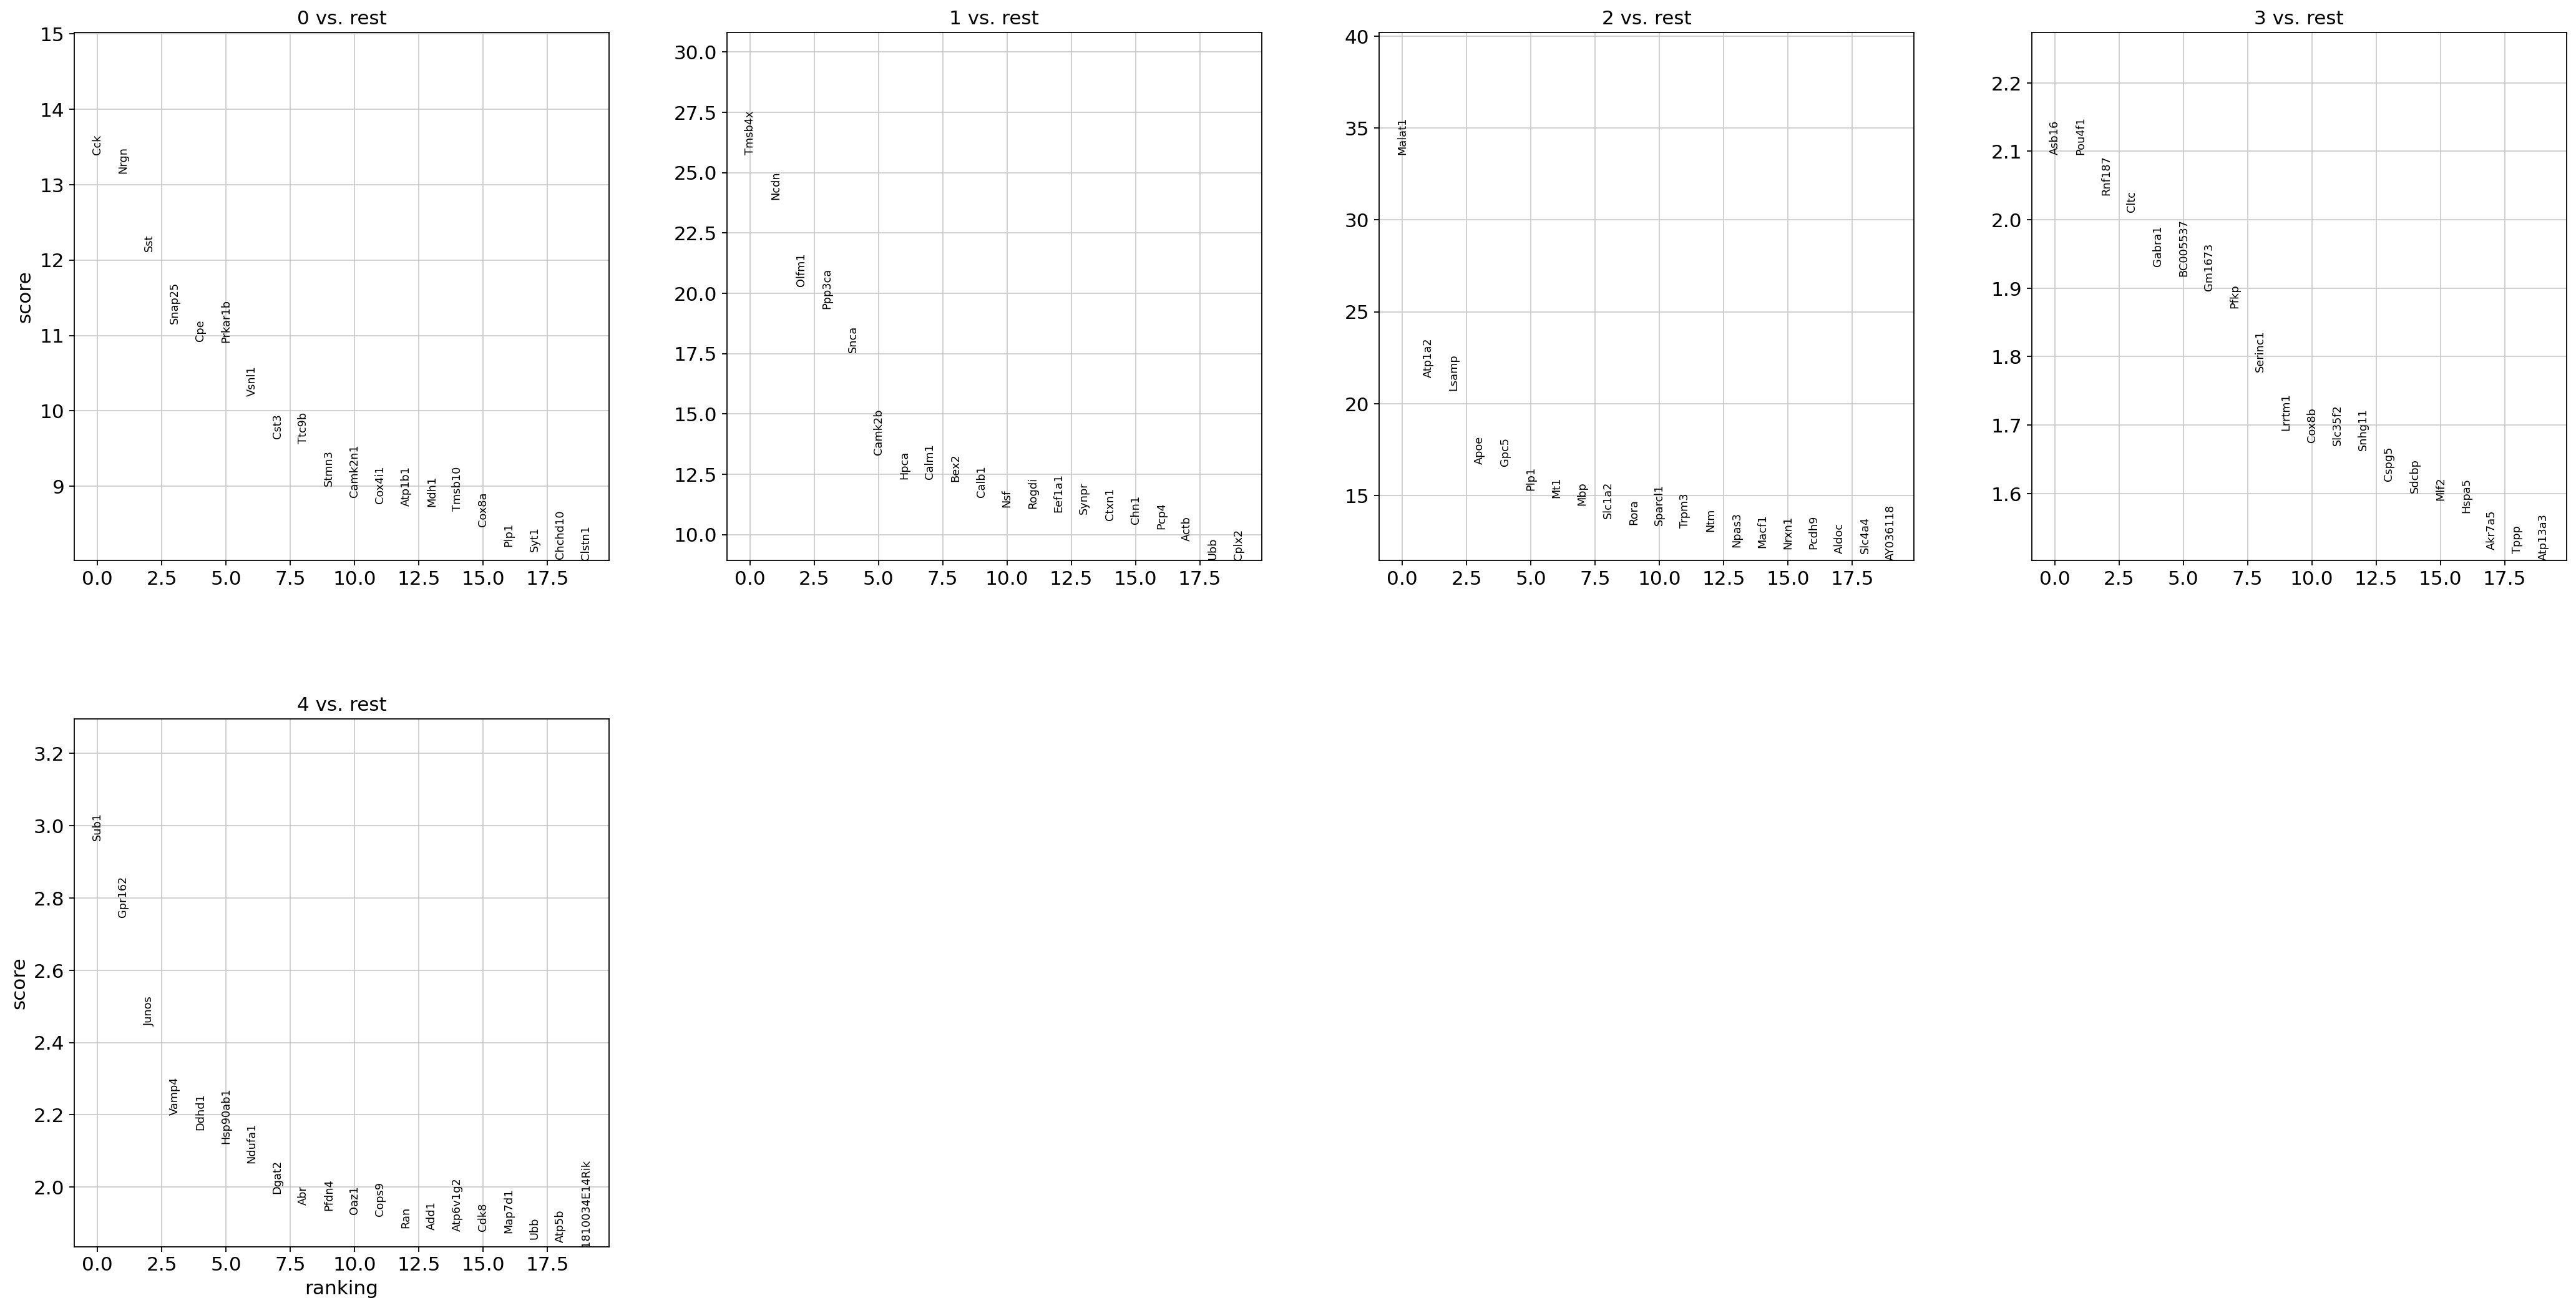


✓ Marker genes overview plot generated


In [25]:
# Overview plot of top marker genes
sc.pl.rank_genes_groups(
    adata,
    n_genes=20,
    sharey=False,
    key='rank_genes_leiden',
    show=True
)

print("\n✓ Marker genes overview plot generated")

In [26]:
# Extract marker genes as a DataFrame
marker_genes_df = sc.get.rank_genes_groups_df(
    adata,
    group=None,  # Get markers for all groups
    key='rank_genes_leiden'
)

print("\nTop 5 marker genes per cluster:")
print("="*80)

for cluster in sorted(adata.obs['leiden'].unique()):
    cluster_markers = marker_genes_df[
        marker_genes_df['group'] == cluster
    ].head(5)

    print(f"\nCluster {cluster}:")
    for idx, row in cluster_markers.iterrows():
        print(f"  {row['names']:15s} | score: {row['scores']:6.2f} | "
              f"logFC: {row['logfoldchanges']:6.2f} | p-val: {row['pvals']:.2e}")


Top 5 marker genes per cluster:

Cluster 0:
  Cck             | score:  13.40 | logFC:   1.59 | p-val: 5.96e-41
  Nrgn            | score:  13.15 | logFC:   1.26 | p-val: 1.70e-39
  Sst             | score:  12.11 | logFC:   2.24 | p-val: 8.95e-34
  Snap25          | score:  11.15 | logFC:   0.99 | p-val: 6.87e-29
  Cpe             | score:  10.92 | logFC:   1.14 | p-val: 9.12e-28

Cluster 1:
  Tmsb4x          | score:  25.76 | logFC:   1.55 | p-val: 2.48e-146
  Ncdn            | score:  23.90 | logFC:   2.56 | p-val: 3.24e-126
  Olfm1           | score:  20.30 | logFC:   1.96 | p-val: 1.28e-91
  Ppp3ca          | score:  19.37 | logFC:   1.86 | p-val: 1.45e-83
  Snca            | score:  17.55 | logFC:   2.00 | p-val: 6.16e-69

Cluster 2:
  Malat1          | score:  33.57 | logFC:   4.95 | p-val: 4.22e-247
  Atp1a2          | score:  21.44 | logFC:   3.74 | p-val: 5.58e-102
  Lsamp           | score:  20.71 | logFC:   4.19 | p-val: 2.64e-95
  Apoe            | score:  16.70 | logFC: 

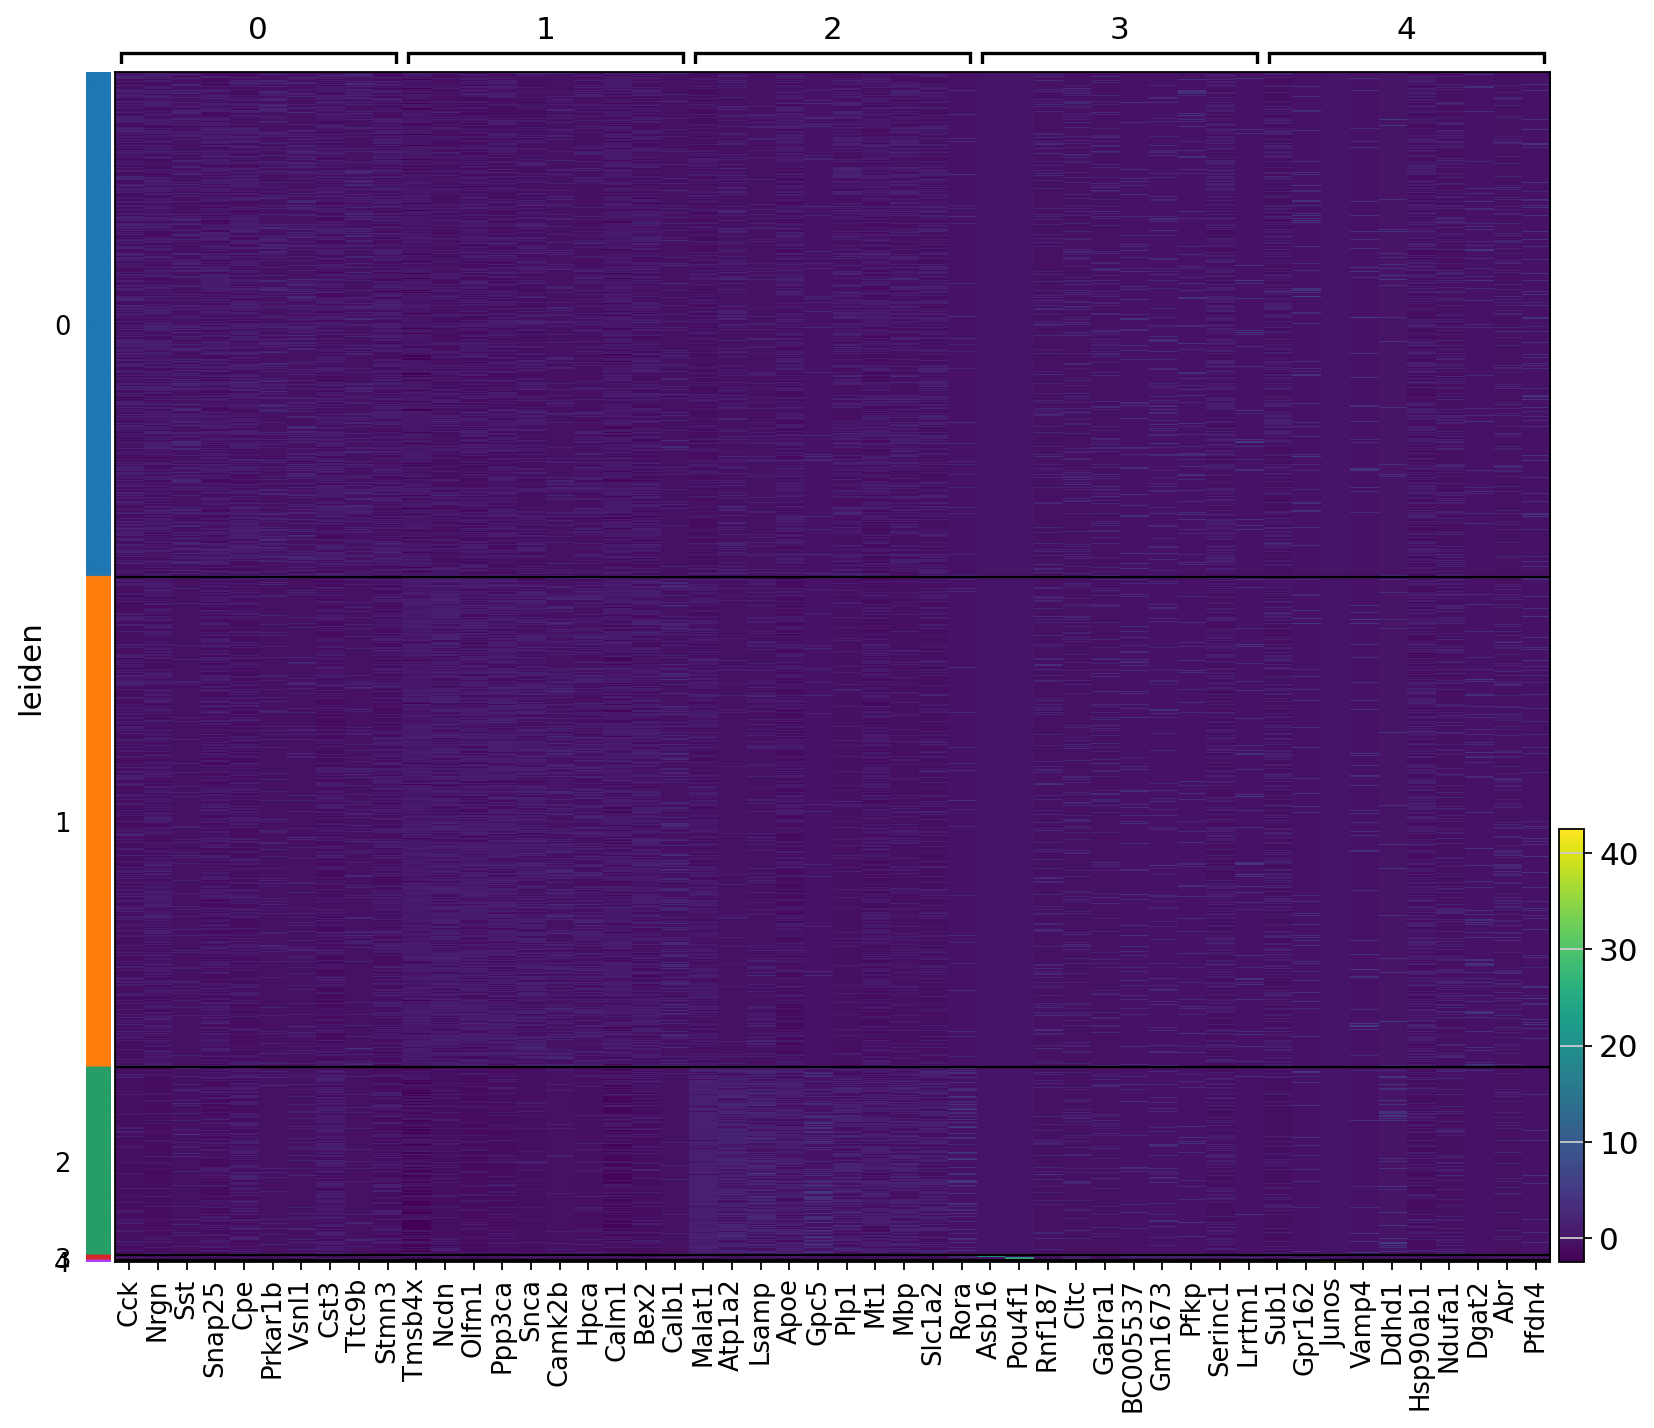


✓ Marker genes heatmap generated


In [27]:
# Heatmap of top marker genes
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=10,
    key='rank_genes_leiden',
    groupby='leiden',
    show_gene_labels=True,
    figsize=(12, 10),
    dendrogram=False,
    show=True
)

print("\n✓ Marker genes heatmap generated")

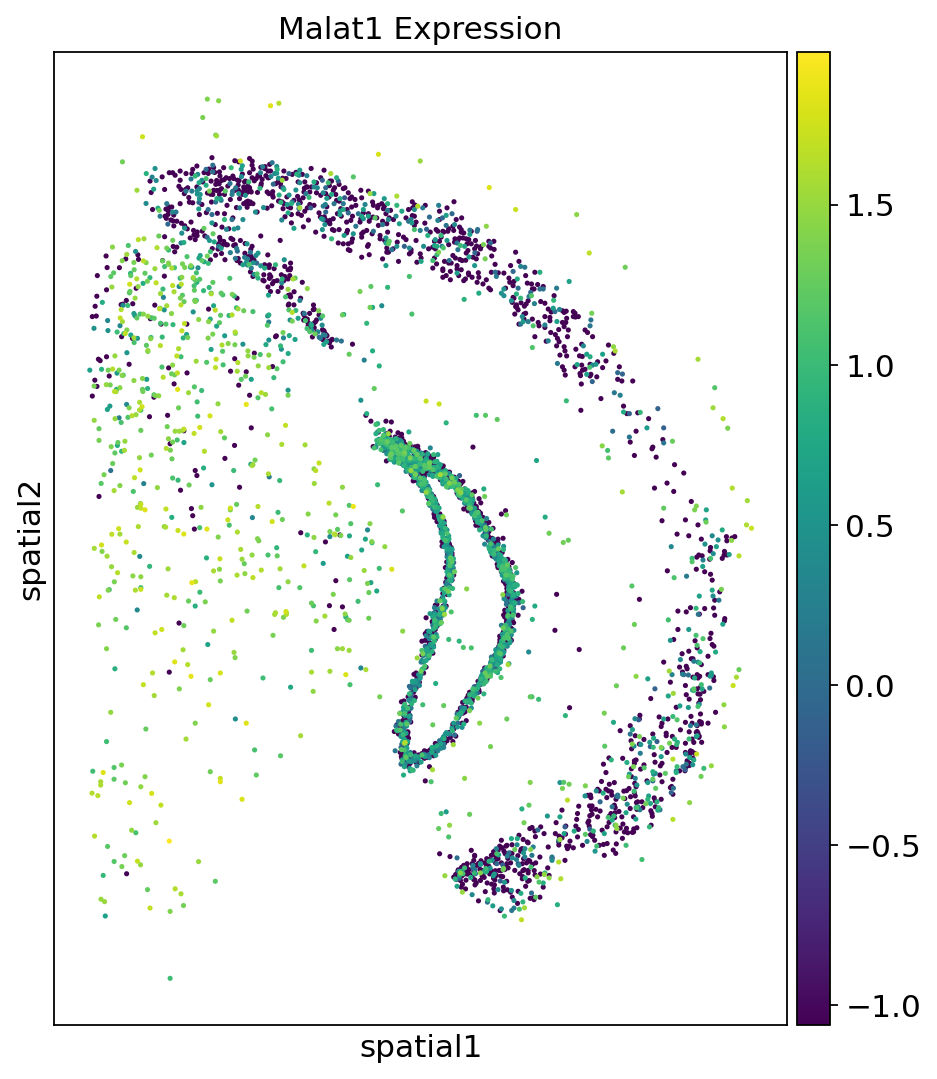

In [28]:
sc.pl.spatial(
    adata,
    color='Malat1',
    size=1.5,       # adjust dot size
    cmap='viridis', # color map
    title='Malat1 Expression',
    spot_size=40,
    show=True
)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


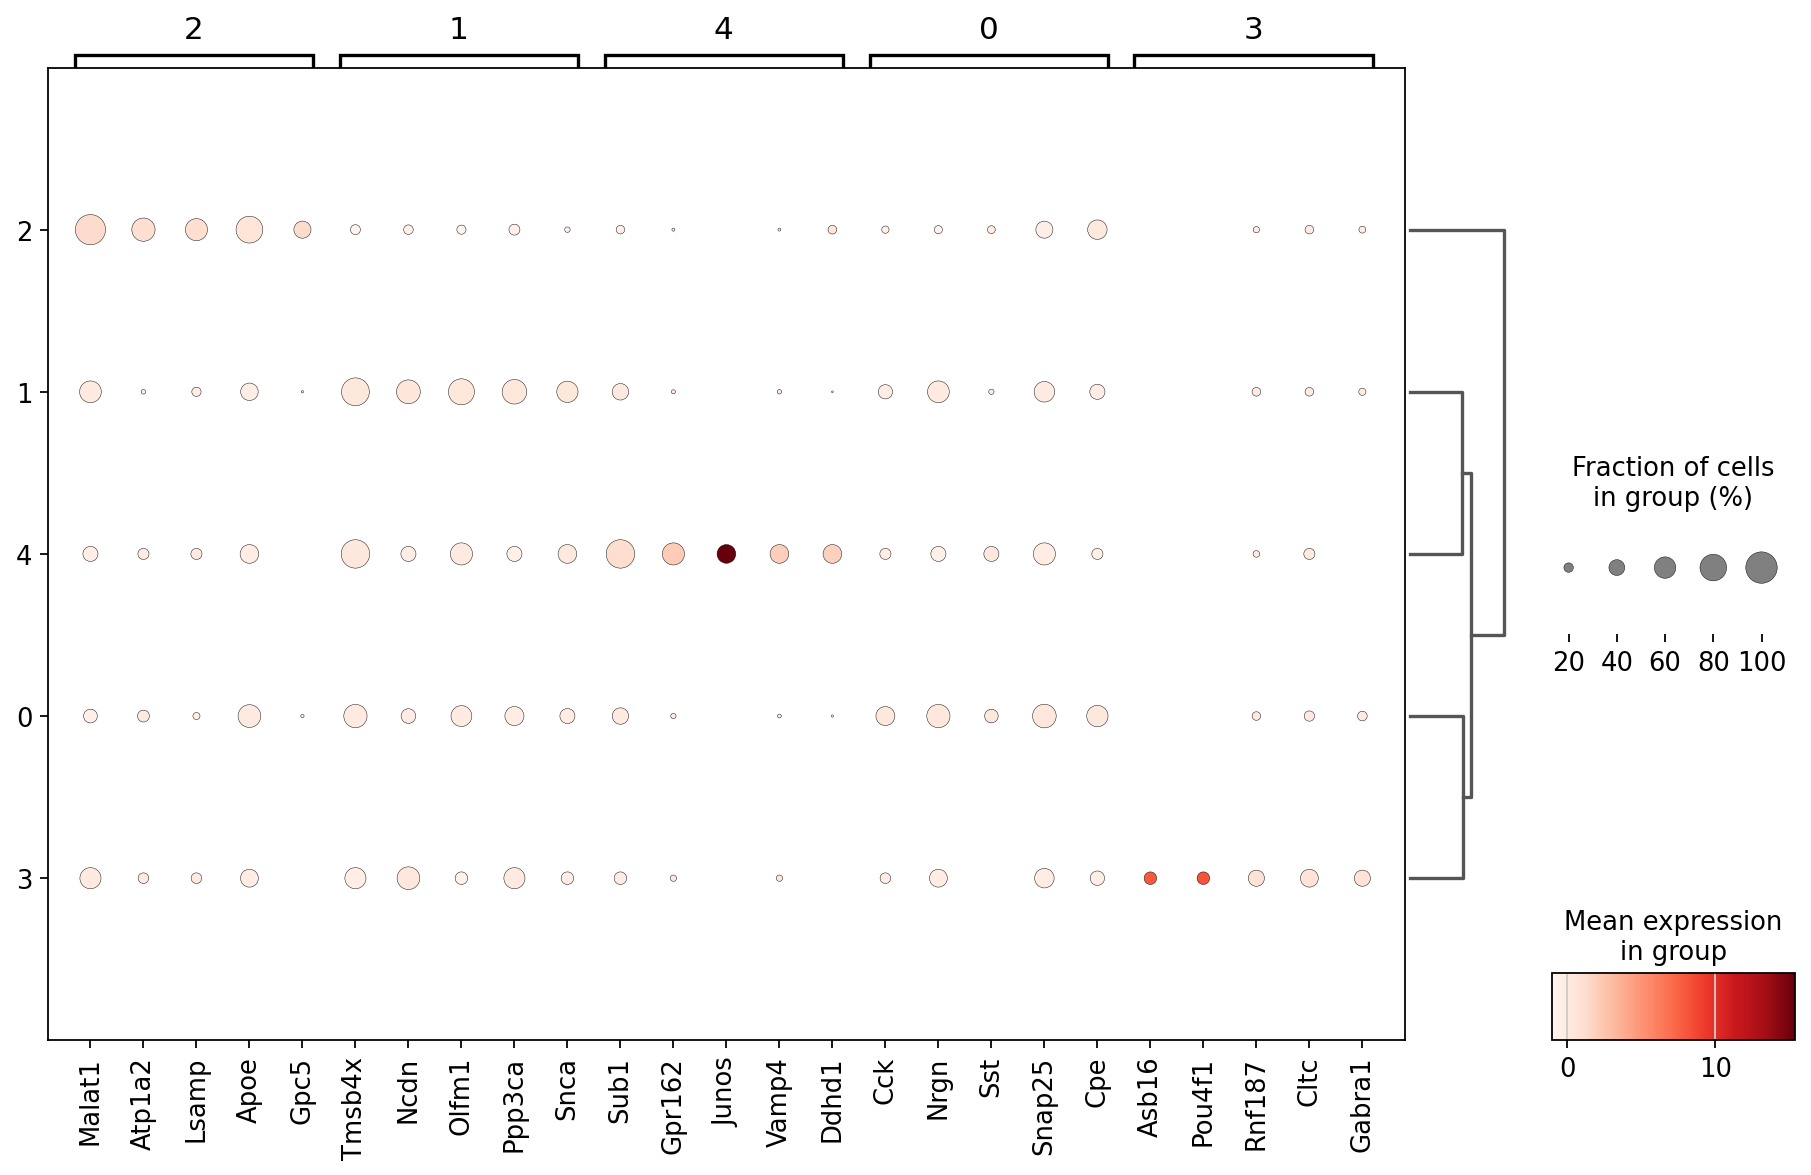


✓ Marker genes dot plot generated


In [29]:
# Dot plot of top marker genes
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=5,
    key='rank_genes_leiden',
    groupby='leiden',
    figsize=(14, 8),
    show=True
)

print("\n✓ Marker genes dot plot generated")

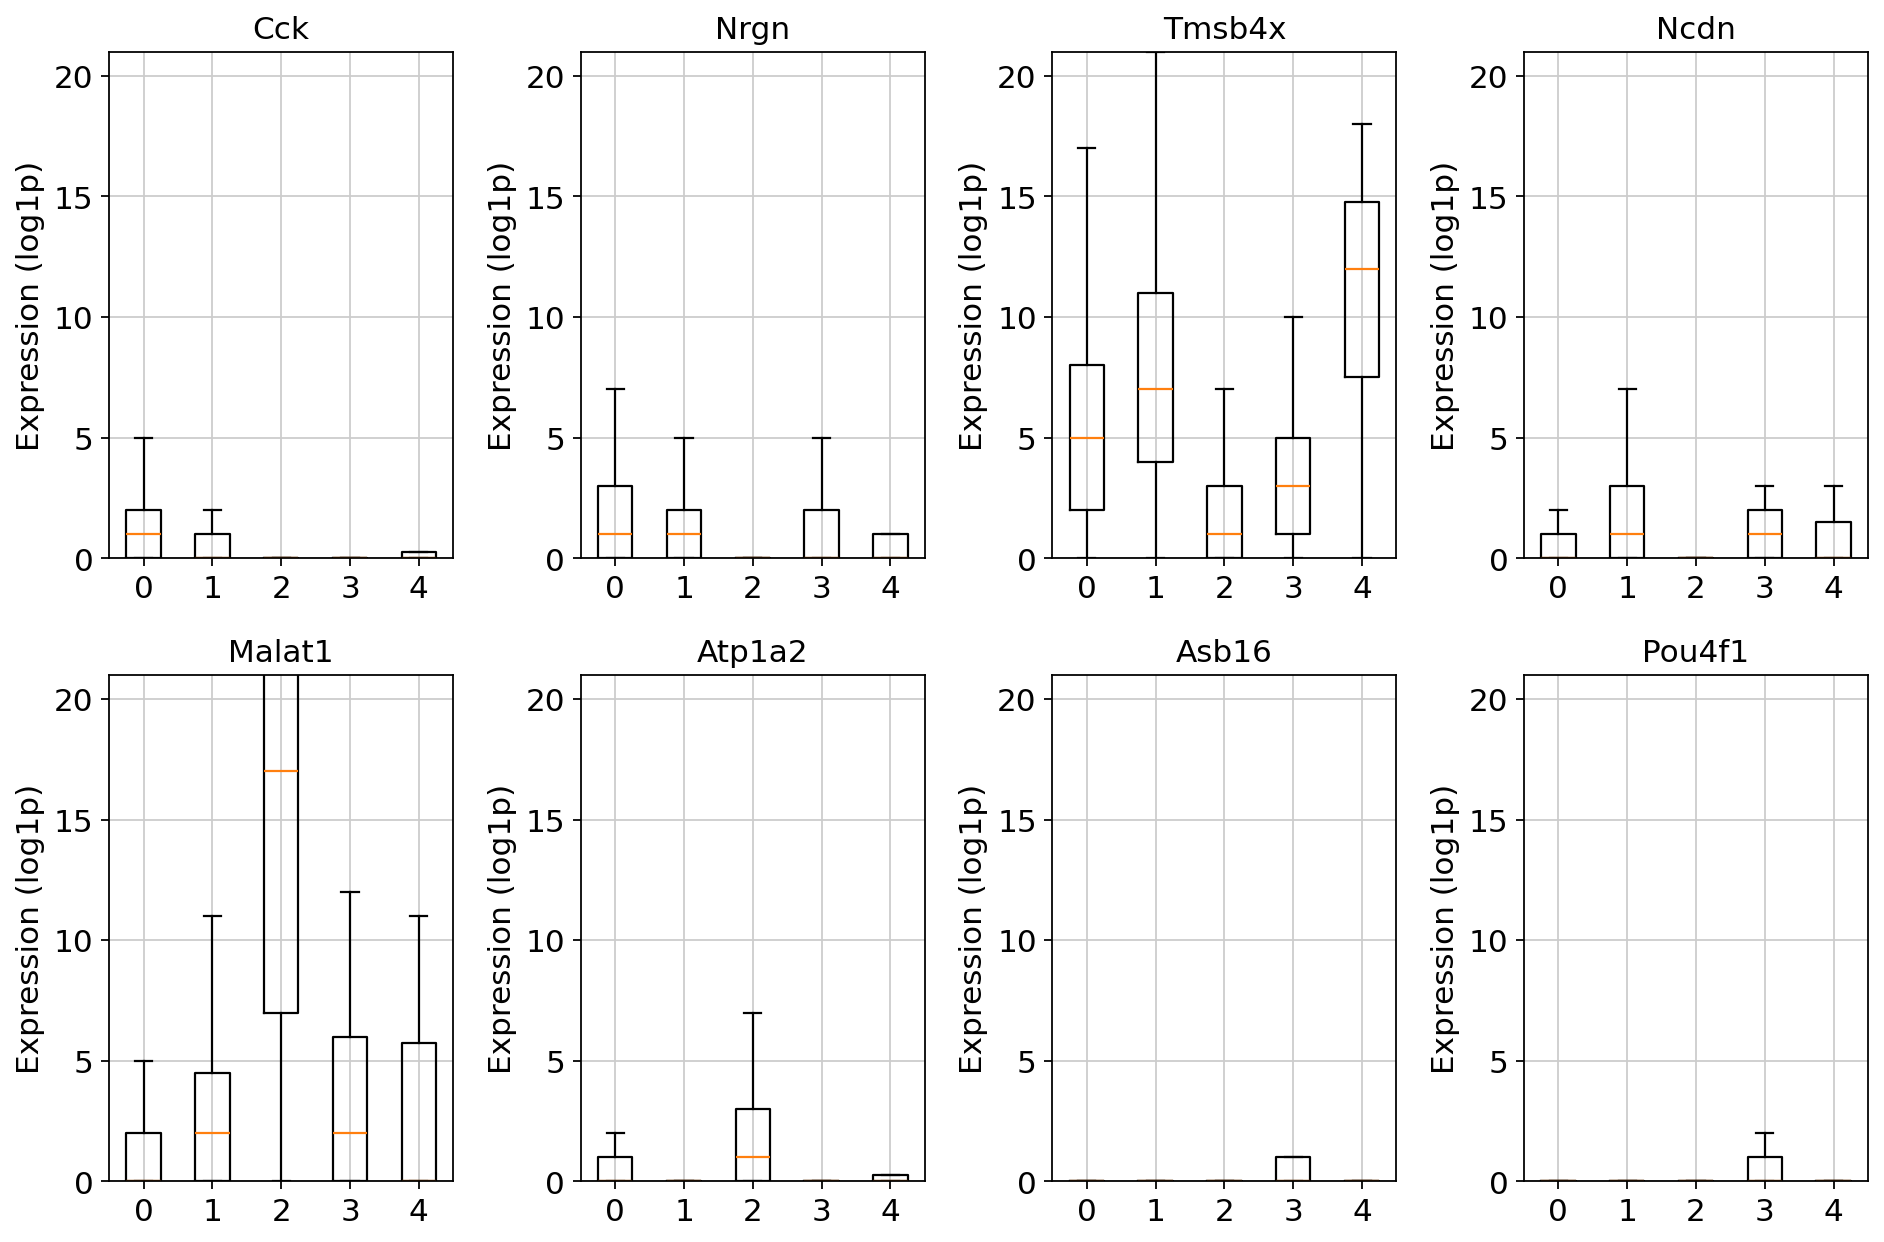


✓ Marker genes plots generated


In [39]:
# Get top 3 marker genes for first 4 clusters for violin plots
top_genes = []
for cluster in sorted(adata.obs['leiden'].unique())[:4]:  # First 4 clusters
    cluster_markers = marker_genes_df[
        marker_genes_df['group'] == cluster
    ].head(2)
    top_genes.extend(cluster_markers['names'].tolist())

# Remove duplicates while preserving order
top_genes = list(dict.fromkeys(top_genes))[:8]  # Limit to 8 genes

# Violin plot
if len(top_genes) > 0:
    genes = top_genes
    clusters = sorted(adata.obs['leiden'].unique())

    # Choose expression source:
    # - adata.X        → usually log1p-normalized
    # - adata.layers[normlog]    → if log1p stored
    # - adata.layers[] → e.g. 'counts'
    gene_idx = [adata.var_names.get_loc(g) for g in genes]
    X = adata.layers["counts"][:, gene_idx]

    # Convert sparse to dense if needed
    if hasattr(X, "toarray"):
        X = X.toarray()

    # Build expression DataFrame
    expr = pd.DataFrame(
        X,
        columns=genes,
        index=adata.obs['leiden']
    )

    # -----------------------------
    # Plot: boxplots in a grid
    # -----------------------------
    n_genes = len(genes)
    n_cols = 4
    n_rows = int(np.ceil(n_genes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    # Optional: consistent y-axis across genes
    ymax = np.percentile(expr.values, 99)

    for ax, gene in zip(axes, genes):
        data = [expr.loc[cluster, gene].values for cluster in clusters]

        ax.boxplot(
            data,
            showfliers=False
        )
        ax.set_title(gene)
        ax.set_xticks(range(1, len(clusters) + 1))
        ax.set_xticklabels(clusters, rotation=0)
        ax.set_ylabel("Expression (log1p)")
        ax.set_ylim(0, ymax)

    # Hide unused panels
    for ax in axes[len(genes):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    print("\n✓ Marker genes plots generated")
else:
    print("\n⚠ No marker genes found for violin plot")

## 12. Spatial Visualization

If spatial coordinates are available, we can visualize clusters in physical space.

✓ Spatial coordinates found! Generating spatial plots...



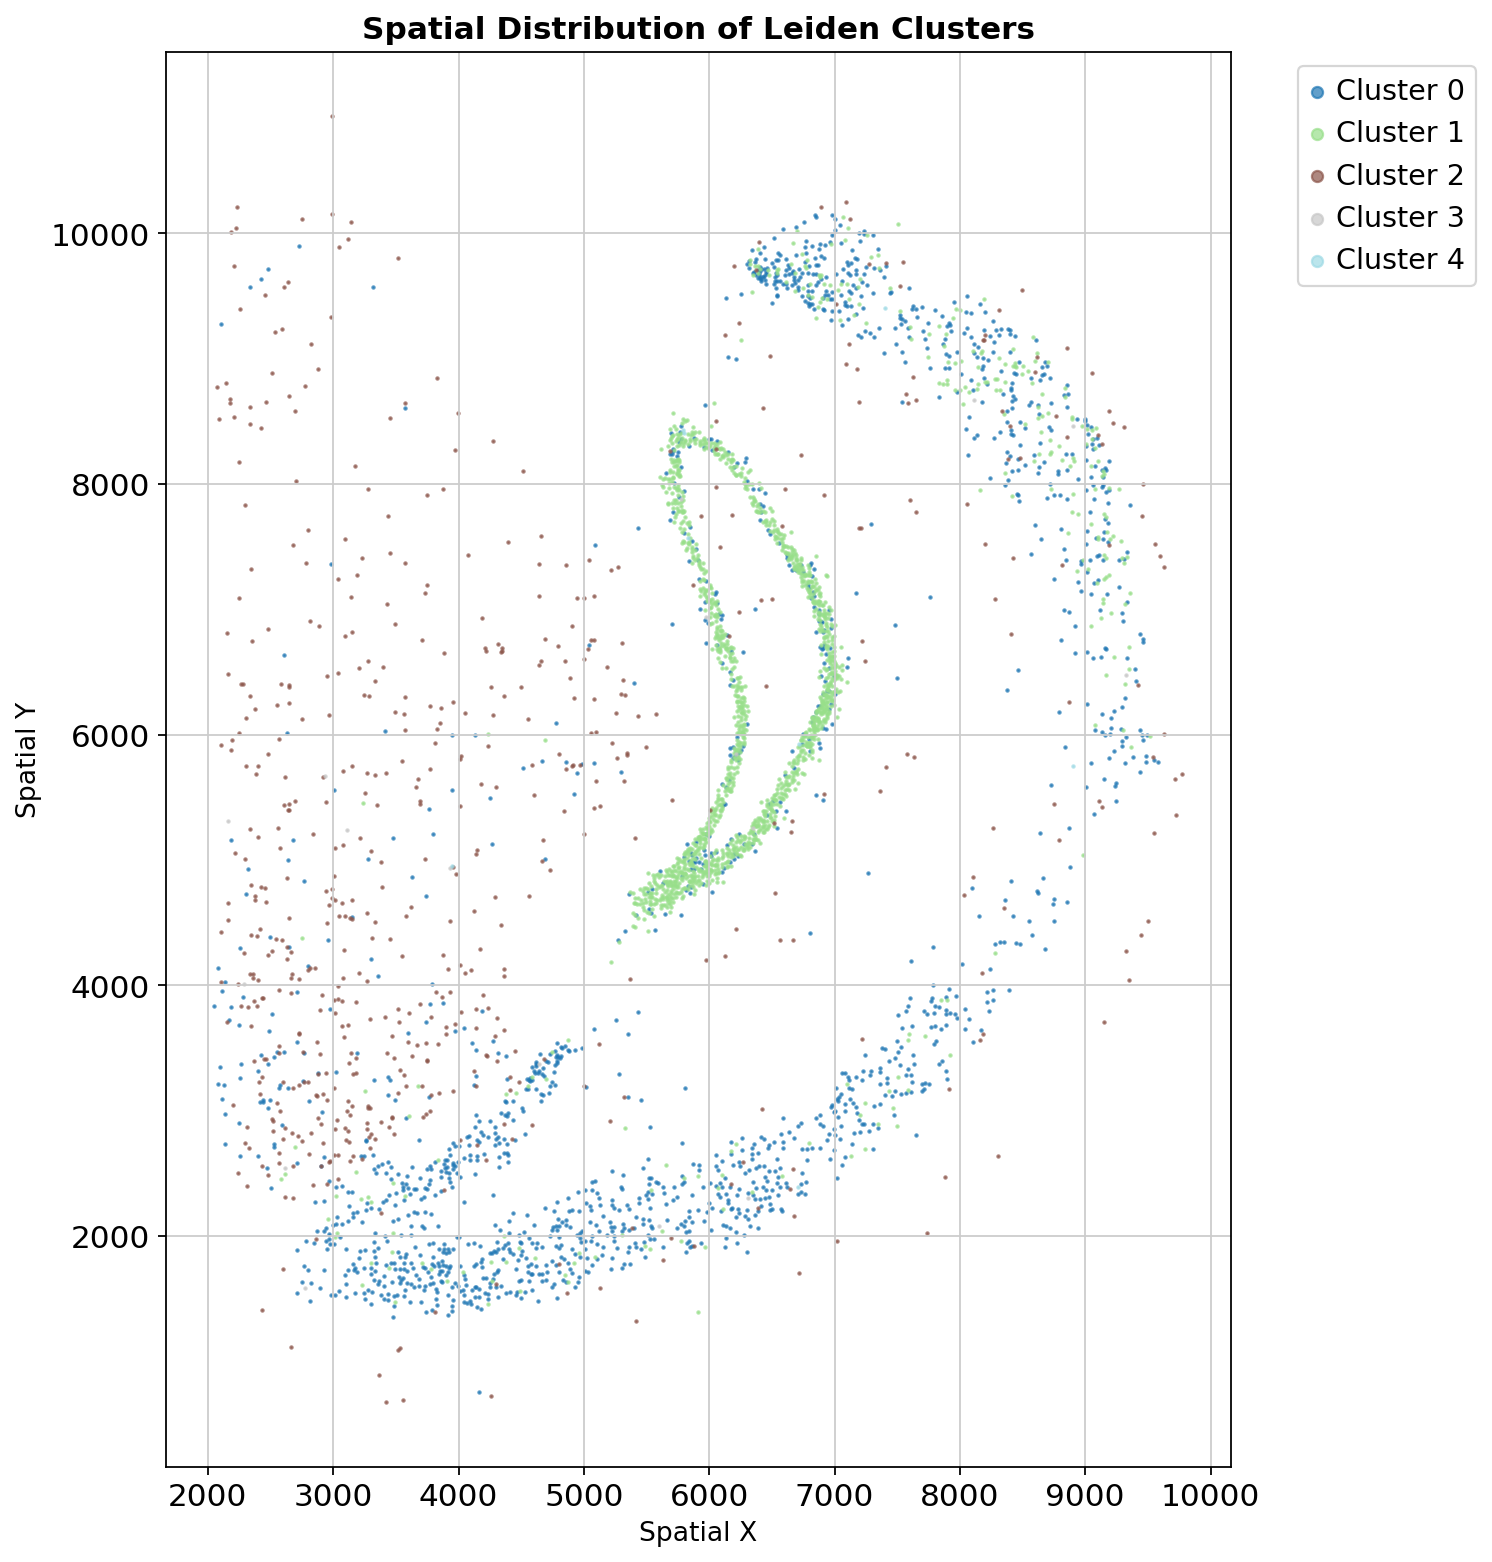


✓ Spatial cluster plot generated


In [40]:
# Check if spatial coordinates are available
if 'spatial' in adata.obsm.keys():
    print("✓ Spatial coordinates found! Generating spatial plots...\n")

    # Spatial scatter colored by Leiden clusters
    fig, ax = plt.subplots(figsize=(10, 10))

    # Get unique clusters and colors
    clusters = adata.obs['leiden'].cat.categories
    colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))

    for i, cluster in enumerate(clusters):
        mask = adata.obs['leiden'] == cluster
        coords = adata.obsm['spatial'][mask]
        ax.scatter(
            coords[:, 0],
            coords[:, 1],
            c=[colors[i]],
            label=f'Cluster {cluster}',
            s=1,
            alpha=0.7
        )

    ax.set_xlabel('Spatial X', fontsize=12)
    ax.set_ylabel('Spatial Y', fontsize=12)
    ax.set_title('Spatial Distribution of Leiden Clusters', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

    print("\n✓ Spatial cluster plot generated")
else:
    print("⚠ No spatial coordinates found in adata.obsm['spatial']")
    print("Spatial visualization skipped.")

## 13. Save Results

Save the processed AnnData object with all analysis results.

In [41]:
# Save processed data
output_path = data_path.replace('.h5ad', '_clustered.h5ad')
adata.write(output_path)

print("\n" + "="*80)
print("RESULTS SAVED")
print("="*80)
print(f"✓ Processed data saved to: {output_path}")
print(f"\nFile size: {os.path.getsize(output_path) / (1024**2):.1f} MB")

print("\nSaved components:")
print("  - Filtered and normalized expression matrix")
print("  - Raw data (adata.layers[counts])")
print("  - PCA embedding")
print("  - UMAP embedding")
print("  - Leiden clusters")
print("  - Louvain clusters")
print("  - Marker genes")
print("  - QC metrics")

# Also save marker genes to CSV
marker_csv_path = data_path.replace('.h5ad', '_markers.csv')
marker_genes_df.to_csv(marker_csv_path, index=False)
print(f"\n✓ Marker genes saved to: {marker_csv_path}")


RESULTS SAVED
✓ Processed data saved to: adult_mouse_brain_ST4k_clustered.h5ad

File size: 486.2 MB

Saved components:
  - Filtered and normalized expression matrix
  - Raw data (adata.layers[counts])
  - PCA embedding
  - UMAP embedding
  - Leiden clusters
  - Louvain clusters
  - Marker genes
  - QC metrics

✓ Marker genes saved to: adult_mouse_brain_ST4k_markers.csv


## 14. Analysis Summary

In [43]:
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print(f"\nFiltered Data:")
print(f"  - Cells: {adata.n_obs:,}")
print(f"  - Genes: {adata.n_vars:,}")
print(f"  - Highly variable genes: {adata.var['highly_variable'].sum():,}")

print(f"\nClustering Results:")
print(f"  - Leiden clusters: {adata.obs['leiden'].nunique()}")

print(f"\nEmbeddings Computed:")
print(f"  - PCA: {adata.obsm['X_pca'].shape[1]} components")
print(f"  - UMAP: 2D embedding")

filtered = marker_genes_df[marker_genes_df['pvals_adj'] < 0.05]

print("\nNumber of significant marker genes per Leiden cluster (pvals_adj < 0.05):")
print("-" * 60)

for cluster, n in filtered['group'].value_counts().sort_index().items():
    print(f"Leiden {cluster}: {n} marker genes")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


ANALYSIS SUMMARY

Filtered Data:
  - Cells: 3,998
  - Genes: 14,556
  - Highly variable genes: 2,000

Clustering Results:
  - Leiden clusters: 5

Embeddings Computed:
  - PCA: 50 components
  - UMAP: 2D embedding

Number of significant marker genes per Leiden cluster (pvals_adj < 0.05):
------------------------------------------------------------
Leiden 0: 211 marker genes
Leiden 1: 330 marker genes
Leiden 2: 573 marker genes
Leiden 3: 0 marker genes
Leiden 4: 0 marker genes

ANALYSIS COMPLETE!
